In [1]:
%pylab inline

import warnings
warnings.filterwarnings("ignore")

import anndata
import pandas as pd
import plotnine as p
from scipy import sparse
p.theme_set(p.theme_classic());

Populating the interactive namespace from numpy and matplotlib


In [2]:
!ls '../starmap-2018/combinatorially_encoded/mpfc_160/'

20180417_BZ5_control       20180421_BZ19_cocaine.h5ad
20180417_BZ5_control.h5ad  20180424_BZ14_control
20180419_BZ9_control       20180424_BZ14_control.h5ad
20180419_BZ9_control.h5ad  Convert to anndata.ipynb
20180421_BZ19_cocaine


In [3]:
starmap_BZ5  = anndata.read('../starmap-2018/combinatorially_encoded/mpfc_160/20180417_BZ5_control.h5ad')
starmap_BZ9  = anndata.read('../starmap-2018/combinatorially_encoded/mpfc_160/20180419_BZ9_control.h5ad')
starmap_BZ14 = anndata.read('../starmap-2018/combinatorially_encoded/mpfc_160/20180424_BZ14_control.h5ad')

In [4]:
starmap = starmap_BZ5.concatenate(starmap_BZ9, starmap_BZ14, batch_categories=['BZ5', 'BZ9', 'BZ14'])

In [5]:
starmap.X = sparse.csr_matrix(starmap.X)

In [6]:
starmap

AnnData object with n_obs × n_vars = 3722 × 166 
    obs: 'x', 'y', 'sample', 'total_counts', 'batch'
    var: 'GeneIdx-BZ5', 'ColorSpaceSeq-BZ5', 'GeneIdx-BZ9', 'ColorSpaceSeq-BZ9', 'GeneIdx-BZ14', 'ColorSpaceSeq-BZ14'

In [7]:
tenex = anndata.read('Zeisel 2018/l1_cortex1.h5ad')

In [80]:
tenex.shape

(13698, 27998)

In [8]:
dropseq = anndata.read('Saunders 2018/F_GRCm38.81.P60Cortex_noRep5_FRONTALonly.has_annotation.h5ad')
print(dropseq.shape)
pick_cells = np.random.choice(np.arange(dropseq.shape[0]), 15000, replace=False)
dropseq = dropseq[pick_cells]

(71639, 29463)


In [9]:
adata = starmap.concatenate(dropseq, tenex, batch_key='dataset', batch_categories=['starmap', 'dropseq', 'tenex'])
adata.X = adata.X.toarray()

to_keep = (adata.X.sum(axis=1) > 0)
adata = adata[to_keep]
adata.X.shape

(32411, 158)

In [10]:
adata.X = adata.X.toarray()

In [11]:
s_m_ = np.mean(adata[adata.obs.query('dataset == "starmap"').index].X, 0)
s_v_ = np.var(adata[adata.obs.query('dataset == "starmap"').index].X, 0)
t_m_ = np.mean(adata[adata.obs.query('dataset == "tenex"').index].X, 0)
t_v_ = np.var(adata[adata.obs.query('dataset == "tenex"').index].X, 0)
d_m_ = np.mean(adata[adata.obs.query('dataset == "dropseq"').index].X, 0)
d_v_ = np.var(adata[adata.obs.query('dataset == "dropseq"').index].X, 0)

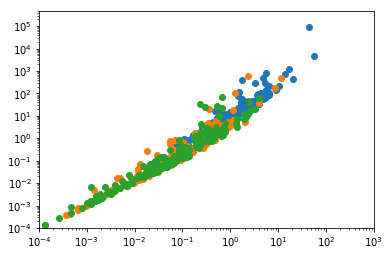

In [12]:
plt.loglog()
plt.scatter(s_m_, s_v_)
plt.scatter(t_m_, t_v_)
plt.scatter(d_m_, d_v_)
plt.xlim(1e-4, 1e3)
plt.ylim(1e-4, 5e5);

In [13]:
s_d_ = np.sum(adata[adata.obs.query('dataset == "starmap"').index].X == 0, 0) \
    / adata.obs.query('dataset == "starmap"').index.shape[0]
t_d_ = np.sum(adata[adata.obs.query('dataset == "tenex"').index].X == 0, 0) \
    / adata.obs.query('dataset == "tenex"').index.shape[0]
d_d_ = np.sum(adata[adata.obs.query('dataset == "dropseq"').index].X == 0, 0) \
    / adata.obs.query('dataset == "dropseq"').index.shape[0]

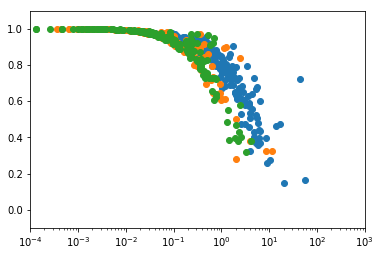

In [14]:
plt.xscale('log')
plt.scatter(s_m_, s_d_)
plt.scatter(t_m_, t_d_)
plt.scatter(d_m_, d_d_)
plt.xlim(1e-4, 1e3)
plt.ylim(-0.1, 1.1);

In [15]:
from fastTSNE import TSNE
from fastTSNE.callbacks import ErrorLogger

In [16]:
tsne = TSNE(negative_gradient_method='fft',
            initialization='random',
            neighbors='approx',
            n_iter=1000,
            callbacks=ErrorLogger(),
            callbacks_every_iters=100,
            n_jobs=-1, 
            learning_rate=300)

In [17]:
from scvi.dataset import GeneExpressionDataset

In [18]:
adata.shape

(32411, 158)

In [19]:
adata.X.shape

(32411, 158)

In [20]:
X, local_means, local_vars, _, labels = GeneExpressionDataset.get_attributes_from_matrix(adata.X)

In [21]:
X.shape

(32411, 158)

In [22]:
local_means.shape

(32411, 1)

In [23]:
batch_indices = adata.obs.dataset.cat.codes.values[:, None].astype(float)

In [24]:
dataset =\
GeneExpressionDataset(X, local_means, local_vars, batch_indices, labels,
                      gene_names=np.array(adata.var.index.values, dtype=str))

In [25]:
from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer, Trainer

In [26]:
vae = VAE(dataset.nb_genes, n_batch=dataset.n_batches, dispersion='gene-batch', n_layers=2, n_hidden=256)

In [27]:
trainer = UnsupervisedTrainer(vae,
                              dataset,
                              train_size=0.75,
                              frequency=1
                             )

In [28]:
trainer.train(n_epochs=100)

training: 100%|██████████| 100/100 [11:14<00:00,  6.74s/it]


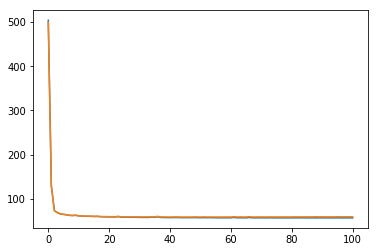

In [29]:
figsize(6, 4)
plt.plot(trainer.history['ll_train_set'])
plt.plot(trainer.history['ll_test_set']);

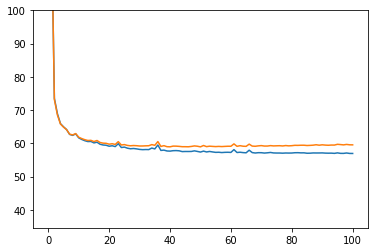

In [30]:
figsize(6, 4)
plt.plot(trainer.history['ll_train_set'])
plt.plot(trainer.history['ll_test_set']);
plt.ylim(ymax=100);

In [31]:
from scvi.inference.posterior import Posterior
pstr = Posterior(vae, dataset, use_cuda=False, data_loader_kwargs={'batch_size': 1024})
Z_hat, b_hat, l_hat = pstr.get_latent()

In [32]:
X.shape

(32411, 158)

In [33]:
Z_hat.shape

(32411, 10)

In [34]:
YY = tsne.fit(Z_hat)

nn 7.984645128250122
Iteration  100, KL divergence  6.0430, 100 iterations in 4.9543 sec
Iteration  200, KL divergence  5.9897, 100 iterations in 4.9363 sec
Iteration  100, KL divergence  3.9968, 100 iterations in 5.1841 sec
Iteration  200, KL divergence  3.5462, 100 iterations in 7.0627 sec
Iteration  300, KL divergence  3.3279, 100 iterations in 10.6049 sec
Iteration  400, KL divergence  3.1945, 100 iterations in 15.0290 sec
Iteration  500, KL divergence  3.1053, 100 iterations in 23.8877 sec
Iteration  600, KL divergence  3.0445, 100 iterations in 27.4424 sec
Iteration  700, KL divergence  3.0046, 100 iterations in 41.8198 sec
Iteration  800, KL divergence  2.9773, 100 iterations in 55.3427 sec
Iteration  900, KL divergence  2.9568, 100 iterations in 63.5284 sec
Iteration  1000, KL divergence  2.9401, 100 iterations in 57.2772 sec
optmization 321.22664499282837


In [35]:
YY.shape

(32411, 2)

In [36]:
adata.shape

(32411, 158)

In [37]:
adata.obs['tSNE_1'] = YY[:, 0]
adata.obs['tSNE_2'] = YY[:, 1]

In [38]:
dsmap = {
    'starmap': 'STARmap (Wang et al 2018)',
    'dropseq': 'Drop-seq (Saunders et al 2018)',
    'tenex': '10X (Zeisel et al 2018)'
}

adata.obs['dataset_nice_'] = adata.obs['dataset'].map(dsmap)

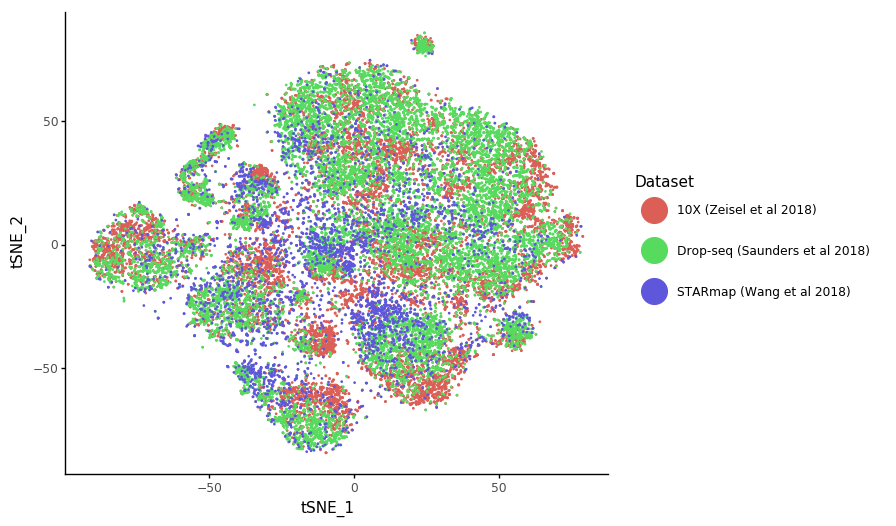

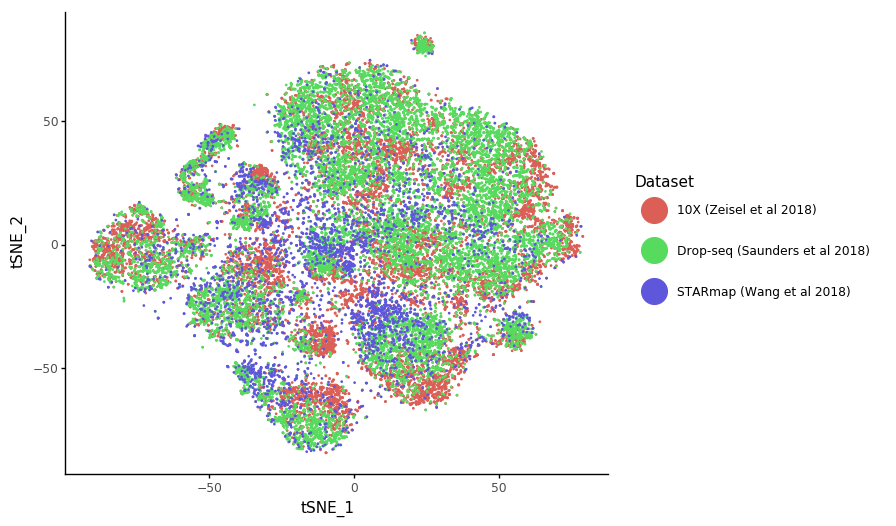

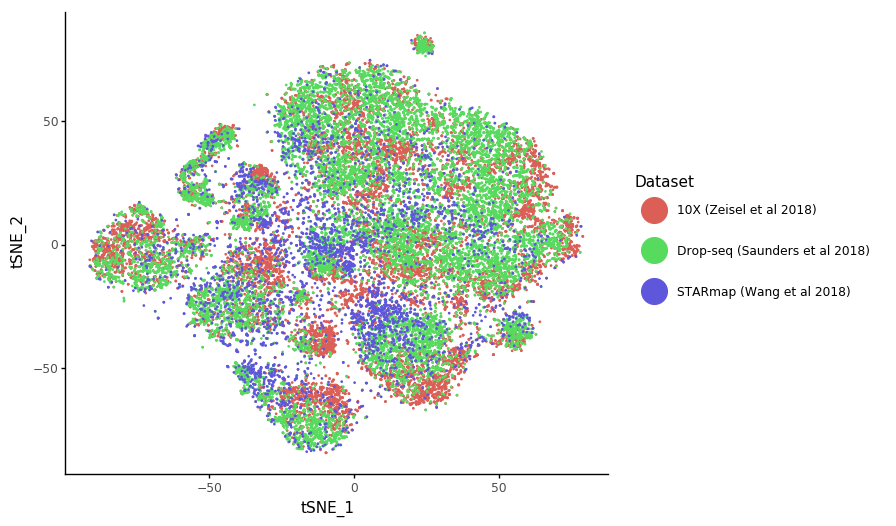

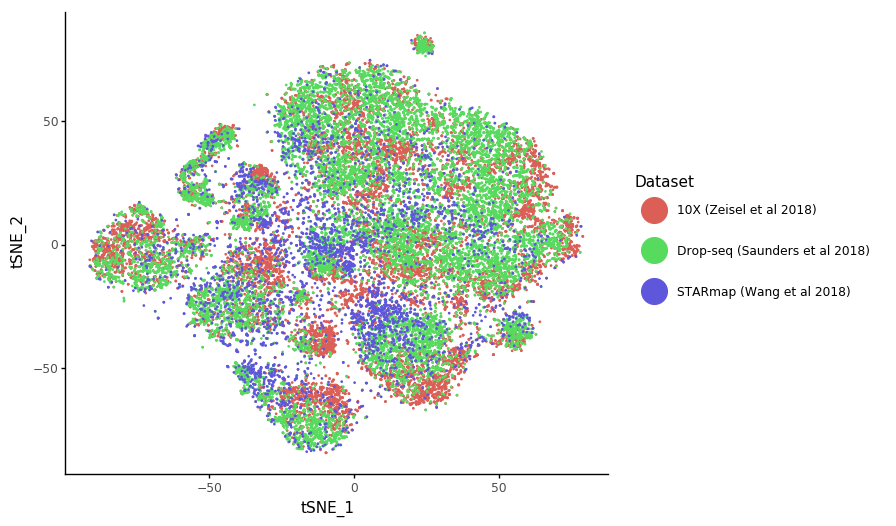

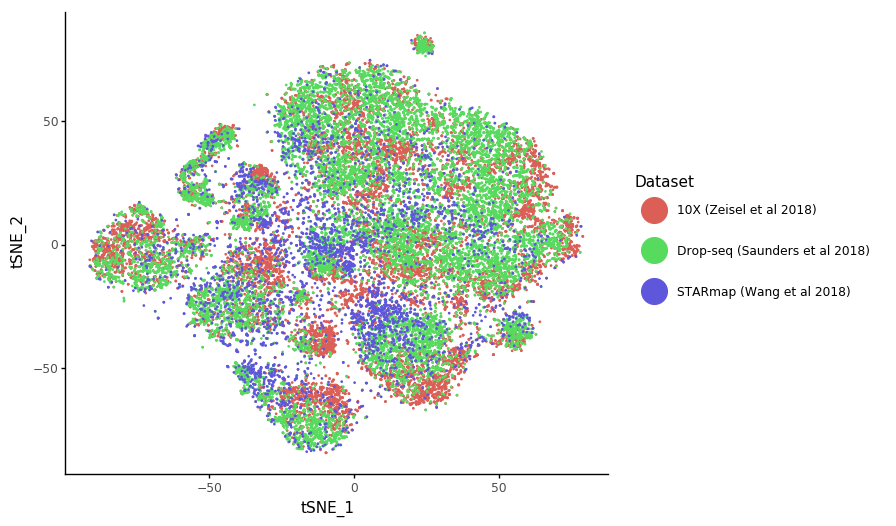

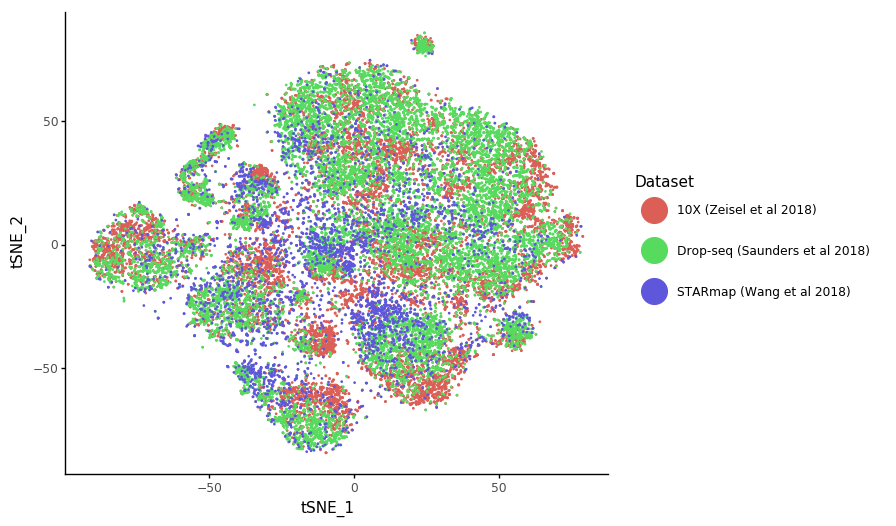

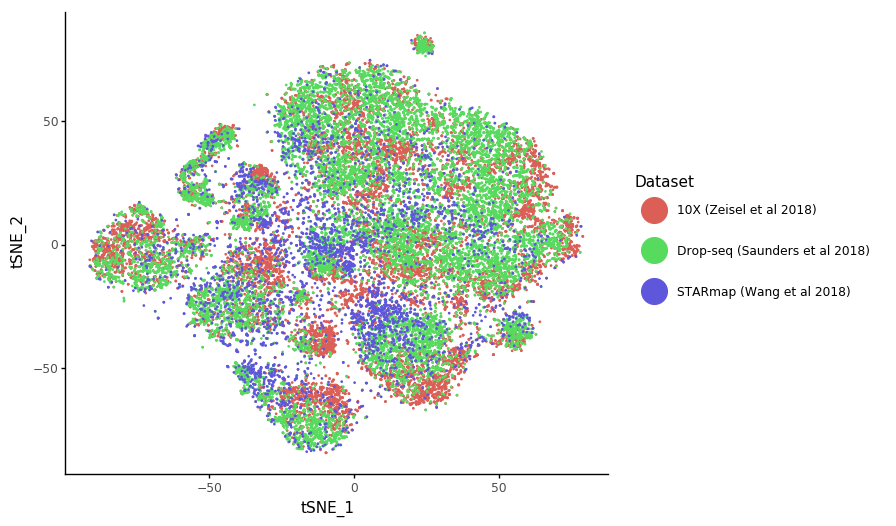

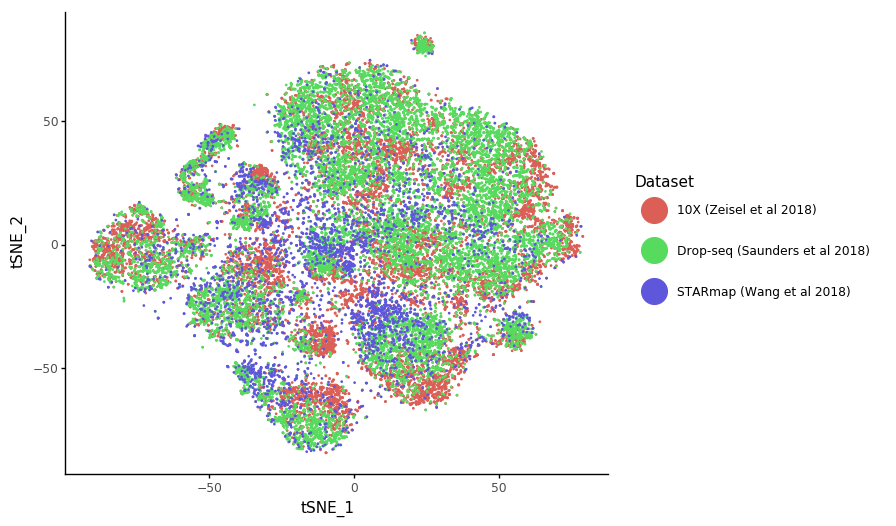

In [81]:
p.options.figure_size = (8, 8)
p.theme_set(p.theme_classic())

pt = \
p.ggplot(p.aes('tSNE_1', 'tSNE_2', color='dataset_nice_'), adata.obs) \
    + p.geom_point(size=0.1) \
    + p.guides(color = p.guide_legend(override_aes={'size': 10})) \
    + p.labs(color='Dataset')

pt.save('global_tsne.png')

<ggplot: (345014234)>

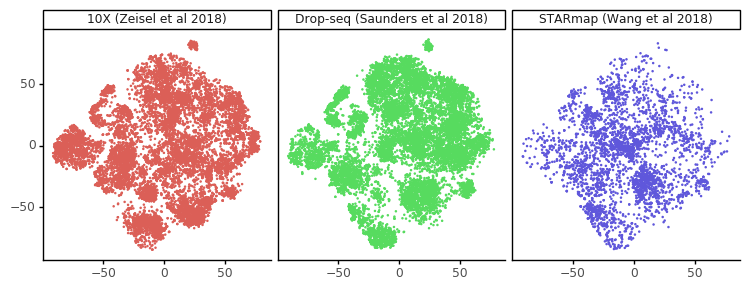

In [83]:
p.options.figure_size = (9, 3)
p.theme_set(p.theme_classic())

pt = \
p.ggplot(p.aes('tSNE_1', 'tSNE_2', color='dataset_nice_'), adata.obs) \
    + p.geom_point(size=0.01, show_legend=False) \
    + p.facet_wrap('dataset_nice_') \
    + p.guides(color = p.guide_legend(override_aes={'size': 5})) \
    + p.labs(color='Dataset', x='', y='')

pt

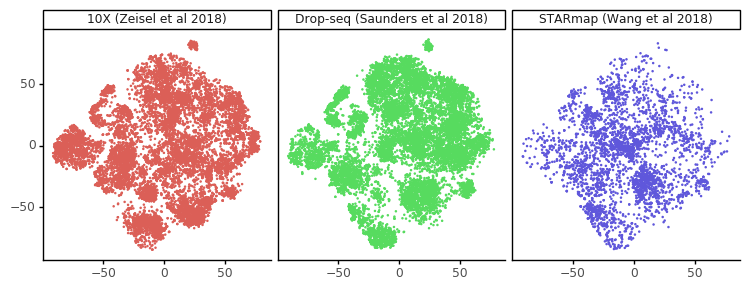

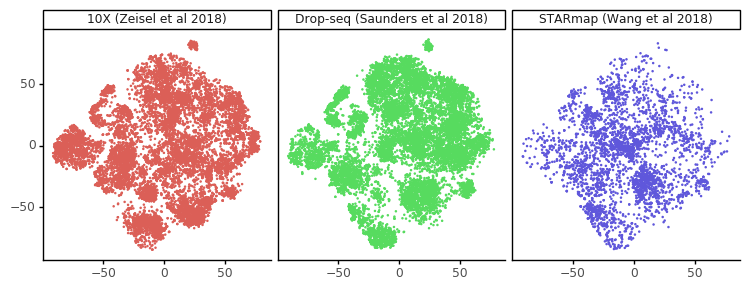

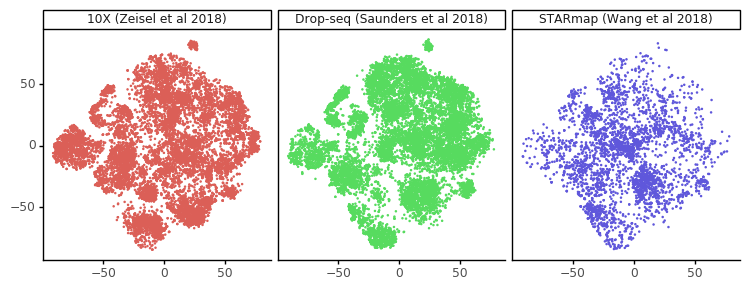

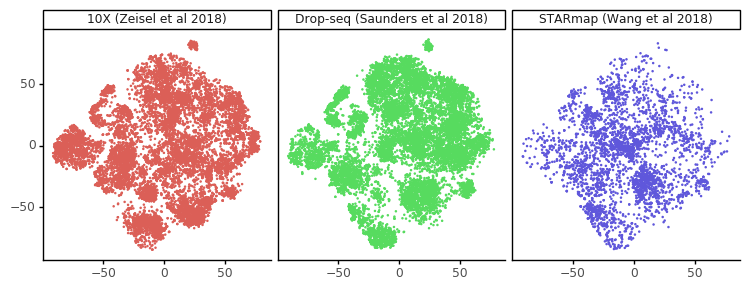

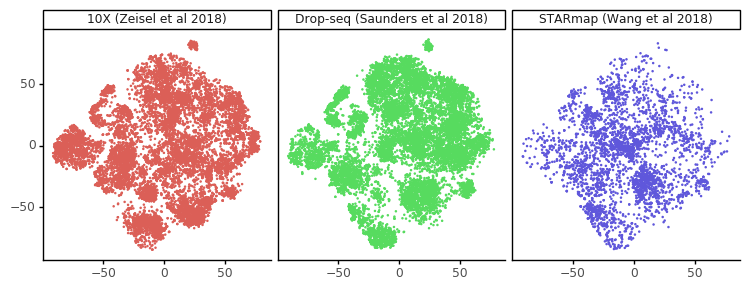

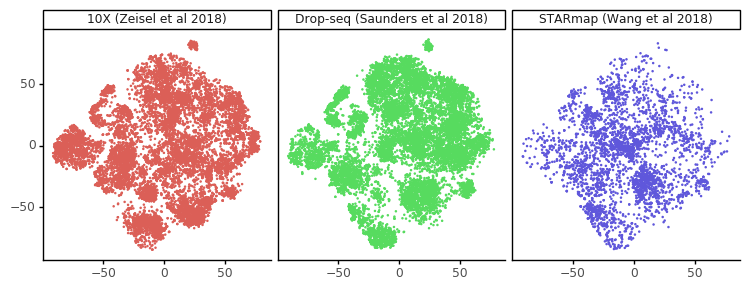

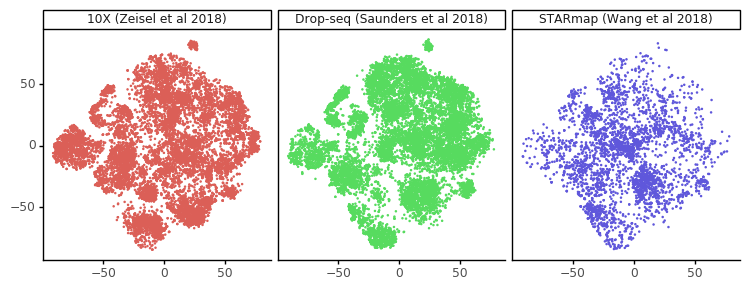

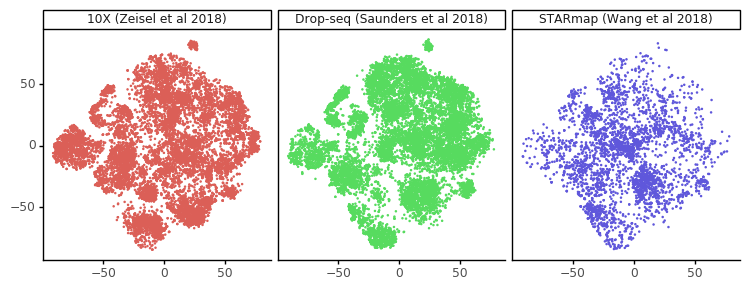

In [85]:
pt.save('stratified_tsne.png', dpi=150);

In [41]:
adata.obs['batch_'] = adata.obs['batch'].values.astype(str)

<ggplot: (294612940)>

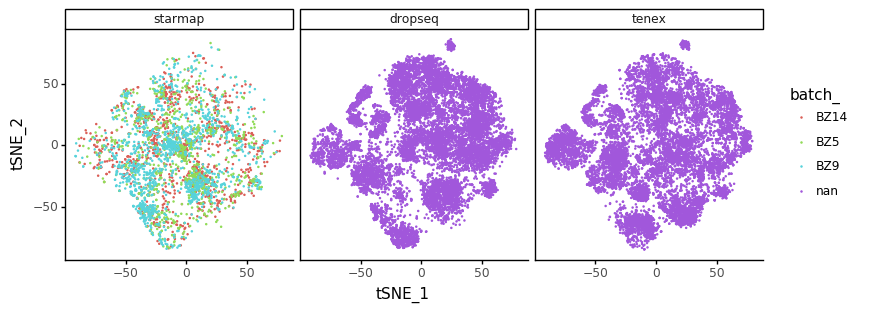

In [42]:
p.ggplot(p.aes('tSNE_1', 'tSNE_2', color='batch_'), adata.obs) \
    + p.geom_point(size=0.01) \
    + p.facet_wrap('dataset')

In [43]:
adata.obs['Subclass_'] = adata.obs['Subclass'].values.astype(str)

<ggplot: (377205999)>

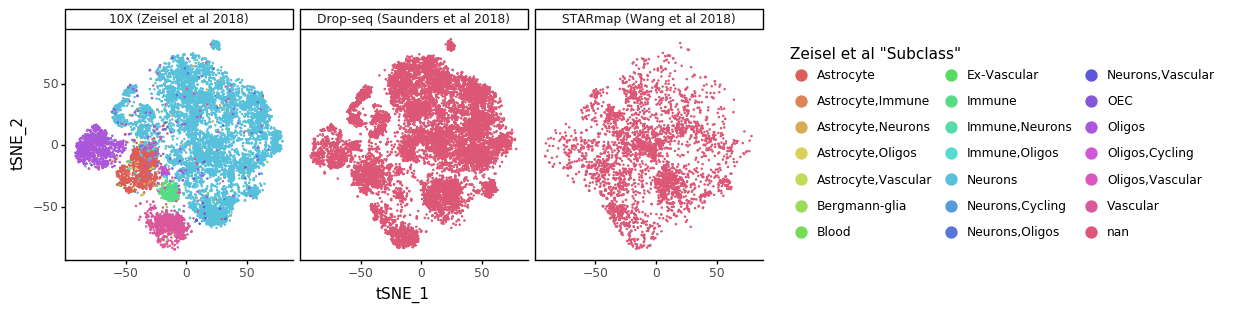

In [86]:
pt = \
p.ggplot(p.aes('tSNE_1', 'tSNE_2', color='Subclass_'), adata.obs) \
    + p.geom_point(size=0.01) \
    + p.facet_wrap('dataset_nice_') \
    + p.guides(color = p.guide_legend(ncol=3, override_aes={'size': 4})) \
    + p.labs(color='Zeisel et al "Subclass"')

pt

In [87]:
pt.save('stratified_tsne_zeisel_subclass.png');

In [45]:
adata.obs['ClusterName_'] = adata.obs['ClusterName'].values.astype(str)

<ggplot: (381044053)>

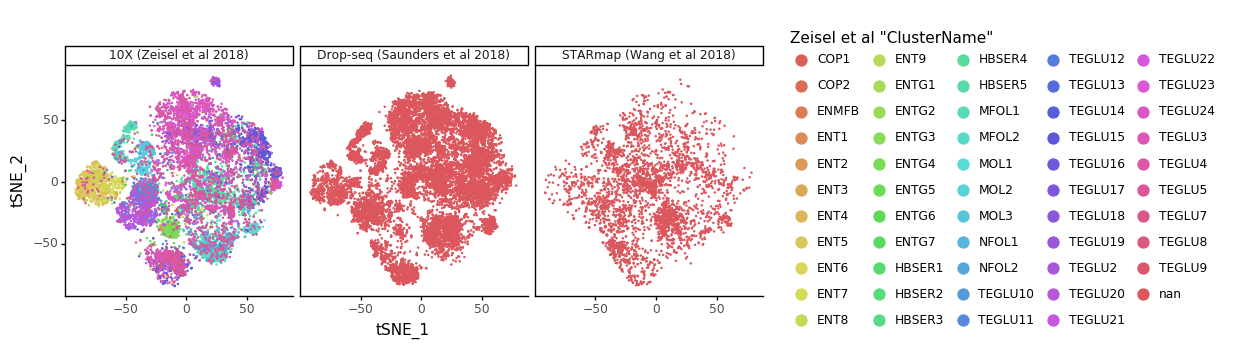

In [88]:
pt = \
p.ggplot(p.aes('tSNE_1', 'tSNE_2', color='ClusterName_'), adata.obs) \
    + p.geom_point(size=0.01) \
    + p.facet_wrap('dataset_nice_') \
    + p.guides(color=p.guide_legend(ncol=5, override_aes={'size': 4})) \
    + p.labs(color='Zeisel et al "ClusterName"')

pt

In [89]:
pt.save('stratified_tsne_zeisel_clustername.png');

In [47]:
adata.obs['class_'] = adata.obs['class'].values.astype(str)

<ggplot: (359315208)>

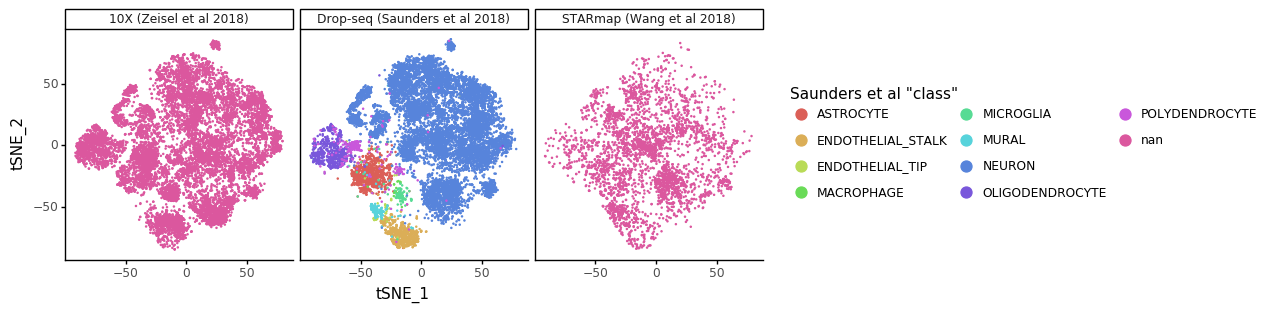

In [90]:
pt = \
p.ggplot(p.aes('tSNE_1', 'tSNE_2', color='class_'), adata.obs) \
    + p.geom_point(size=0.01) \
    + p.facet_wrap('dataset_nice_') \
    + p.guides(color=p.guide_legend(ncol=3, override_aes={'size': 4})) \
    + p.labs(color='Saunders et al "class"')
pt

In [92]:
pt.save('stratified_tsne_saunders_class.png');

In [49]:
adata.obs['common_name_'] = adata.obs['common_name'].values.astype(str)

<ggplot: (336762120)>

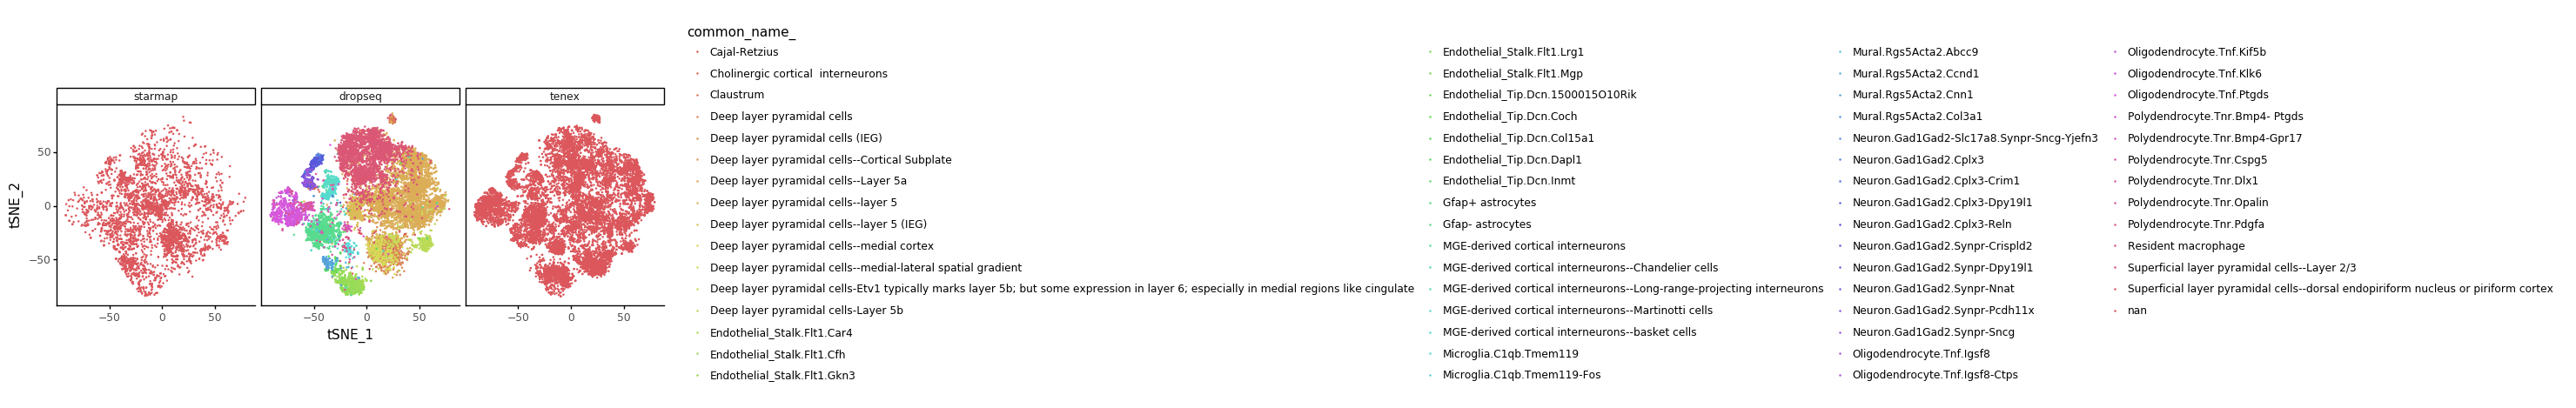

In [50]:
p.ggplot(p.aes('tSNE_1', 'tSNE_2', color='common_name_'), adata.obs) \
    + p.geom_point(size=0.01) \
    + p.facet_wrap('dataset')

In [51]:
adata.obs['common_name_short_'] = adata.obs['common_name_'].str.slice(0, 27)

<ggplot: (-9223372036487895650)>

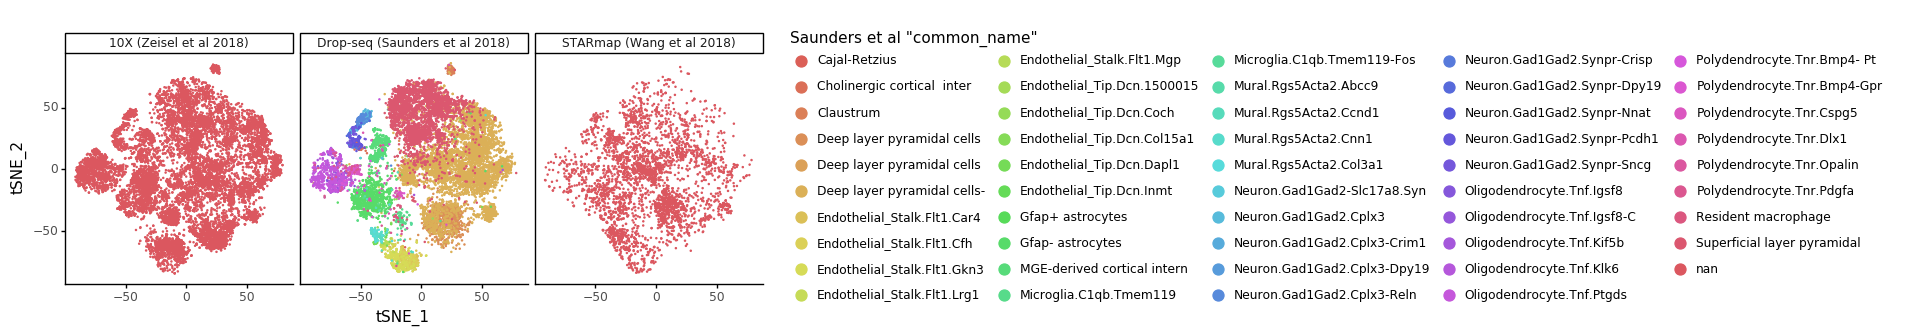

In [93]:
pt = \
p.ggplot(p.aes('tSNE_1', 'tSNE_2', color='common_name_short_'), adata.obs) \
    + p.geom_point(size=0.01) \
    + p.facet_wrap('dataset_nice_') \
    + p.guides(color=p.guide_legend(ncol=5, override_aes={'size': 4})) \
    + p.labs(color='Saunders et al "common_name"')

pt

In [94]:
pt.save('stratified_tsne_saunders_commonnameshort.png');

In [95]:
from sklearn.neighbors import KNeighborsClassifier

In [96]:
nn = KNeighborsClassifier()

In [97]:
for i, z in enumerate(Z_hat.T):
    adata.obs[f'z_{i}'] = z

In [98]:
z_cols = [f'z_{i}' for i in range(10)]

In [99]:
t_obs = adata.obs.query('dataset == "tenex"').copy()

In [100]:
t_z = t_obs[z_cols].values

In [101]:
s_obs = adata.obs.query('dataset == "starmap"').copy()
s_z = s_obs[z_cols].values

In [102]:
t_y = t_obs['ClusterName'].values
nn.fit(t_z, t_y)
s_obs['predicted_cluster'] = nn.predict(s_z)

<ggplot: (-9223372036503653621)>

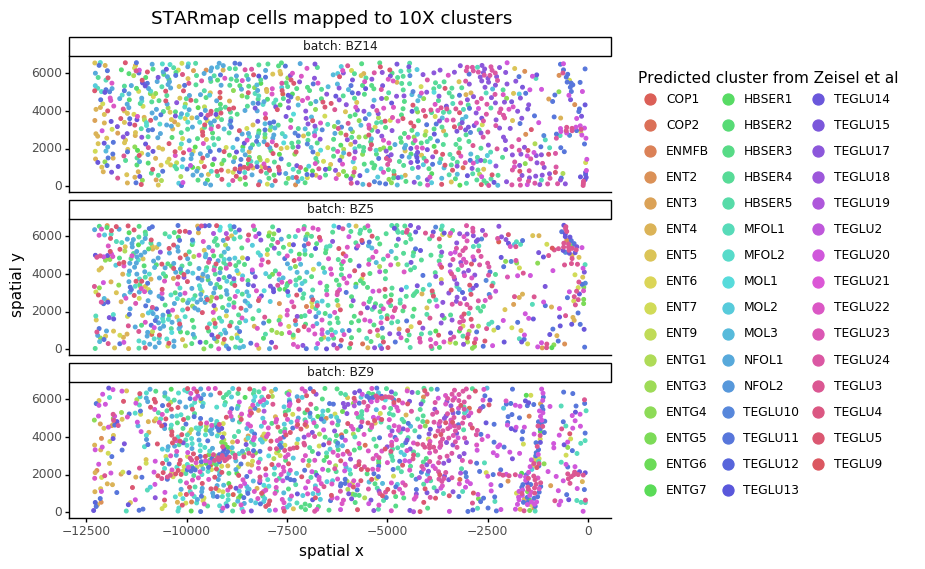

In [103]:
p.options.figure_size = (7, 6)
p.theme_set(p.theme_classic())

pt = \
p.ggplot(p.aes('-y', 'x', color='predicted_cluster'), s_obs) \
    + p.geom_point(size=1) \
    + p.facet_wrap('batch', ncol=1, labeller='label_both') \
    + p.labs(x='spatial x', y='spatial y',
             title='STARmap cells mapped to 10X clusters',
             color='Predicted cluster from Zeisel et al') \
    + p.guides(color=p.guide_legend(ncol=3, override_aes={'size': 4}))

pt

In [104]:
pt.save('starmap_predict_zeisel_clusters.png');

In [62]:
d_obs = adata.obs.query('dataset == "dropseq"')
d_z = d_obs[z_cols].values

In [105]:
d_y = d_obs['common_name_short_'].values
nn.fit(d_z, d_y)
s_obs['predicted_cluster'] = nn.predict(s_z)

<ggplot: (381413110)>

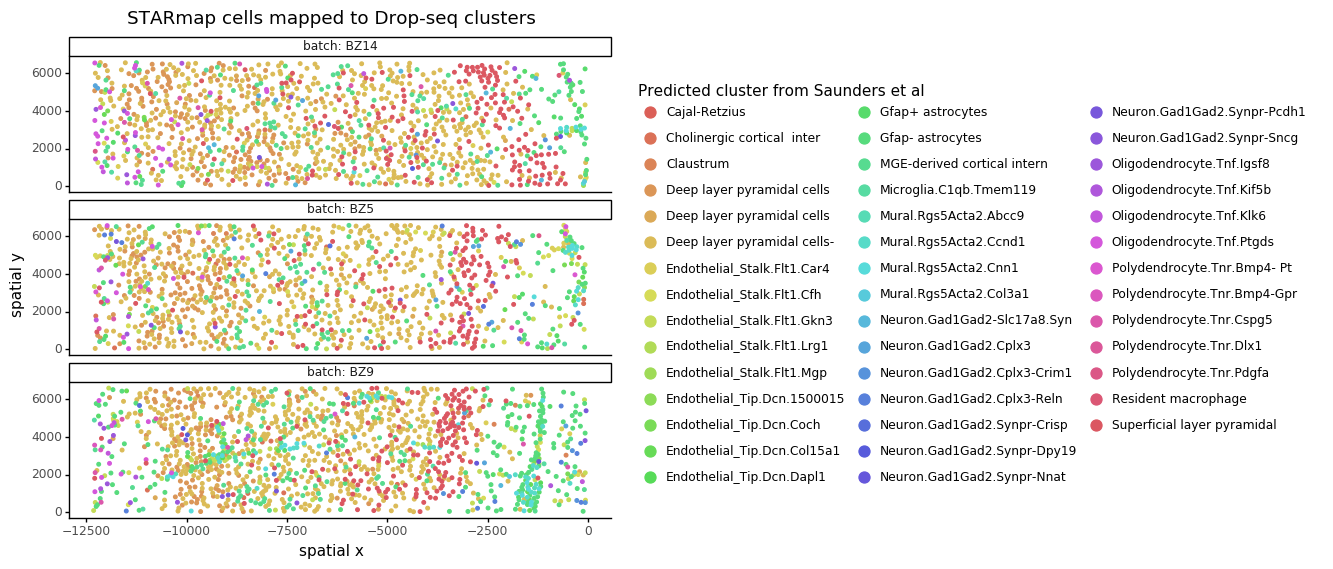

In [107]:
pt = \
p.ggplot(p.aes('-y', 'x', color='predicted_cluster'), s_obs) \
    + p.geom_point(size=1) \
    + p.facet_wrap('batch', ncol=1, labeller='label_both') \
    + p.labs(x='spatial x', y='spatial y',
             title='STARmap cells mapped to Drop-seq clusters',
             color='Predicted cluster from Saunders et al') \
    + p.guides(color=p.guide_legend(ncol=3, override_aes={'size': 4}))

pt

In [108]:
pt.save('starmap_predict_saunders_clusters.png');

In [65]:
', '.join(t_obs.columns)

'Age, AnalysisPool, AnalysisProject, CellConc, Cell_Conc, ChipID, Class, ClassProbability_Astrocyte, ClassProbability_Astrocyte,Immune, ClassProbability_Astrocyte,Neurons, ClassProbability_Astrocyte,Oligos, ClassProbability_Astrocyte,Vascular, ClassProbability_Bergmann-glia, ClassProbability_Blood, ClassProbability_Blood,Vascular, ClassProbability_Enteric-glia, ClassProbability_Enteric-glia,Cycling, ClassProbability_Ependymal, ClassProbability_Ex-Neurons, ClassProbability_Ex-Vascular, ClassProbability_Immune, ClassProbability_Immune,Neurons, ClassProbability_Immune,Oligos, ClassProbability_Neurons, ClassProbability_Neurons,Cycling, ClassProbability_Neurons,Oligos, ClassProbability_Neurons,Satellite-glia, ClassProbability_Neurons,Vascular, ClassProbability_OEC, ClassProbability_Oligos, ClassProbability_Oligos,Cycling, ClassProbability_Oligos,Vascular, ClassProbability_Satellite-glia, ClassProbability_Satellite-glia,Cycling, ClassProbability_Satellite-glia,Schwann, ClassProbability_Schwa

In [66]:
tenex

AnnData object with n_obs × n_vars = 13698 × 27998 
    obs: 'Age', 'AnalysisPool', 'AnalysisProject', 'CellConc', 'Cell_Conc', 'ChipID', 'Class', 'ClassProbability_Astrocyte', 'ClassProbability_Astrocyte,Immune', 'ClassProbability_Astrocyte,Neurons', 'ClassProbability_Astrocyte,Oligos', 'ClassProbability_Astrocyte,Vascular', 'ClassProbability_Bergmann-glia', 'ClassProbability_Blood', 'ClassProbability_Blood,Vascular', 'ClassProbability_Enteric-glia', 'ClassProbability_Enteric-glia,Cycling', 'ClassProbability_Ependymal', 'ClassProbability_Ex-Neurons', 'ClassProbability_Ex-Vascular', 'ClassProbability_Immune', 'ClassProbability_Immune,Neurons', 'ClassProbability_Immune,Oligos', 'ClassProbability_Neurons', 'ClassProbability_Neurons,Cycling', 'ClassProbability_Neurons,Oligos', 'ClassProbability_Neurons,Satellite-glia', 'ClassProbability_Neurons,Vascular', 'ClassProbability_OEC', 'ClassProbability_Oligos', 'ClassProbability_Oligos,Cycling', 'ClassProbability_Oligos,Vascular', 'ClassProbabi

In [67]:
tenex.obs._Valid.value_counts()

1    13698
Name: _Valid, dtype: int64

In [68]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [69]:
d_c_means = d_obs.groupby('class_').mean()[z_cols]

In [70]:
Zlink = linkage(d_c_means, method='ward')

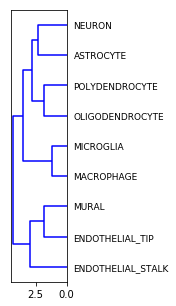

In [71]:
figsize(1, 5)
dendrogram(Zlink, labels=d_c_means.index, color_threshold=0, orientation='left', leaf_font_size=9);

In [72]:
t_c_means = t_obs.groupby('Subclass_').mean()[z_cols]
t_c_means.index = '* ' + t_c_means.index

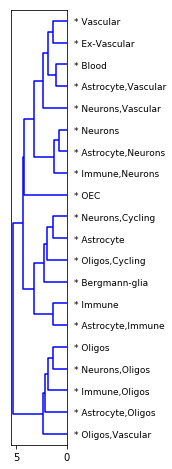

In [73]:
figsize(1, 8)
Zlink = linkage(t_c_means, method='ward')
dendrogram(Zlink, labels=t_c_means.index, color_threshold=0, orientation='left', leaf_font_size=9);

In [109]:
d_c_means = d_obs.groupby('class_').mean()[z_cols]
d_c_means.index = '(Saunders et al)   ' + d_c_means.index
t_c_means = t_obs.groupby('Subclass_').mean()[z_cols]
t_c_means.index = '(Zeisel et al)        ' + t_c_means.index
c_means = pd.concat((t_c_means, d_c_means))

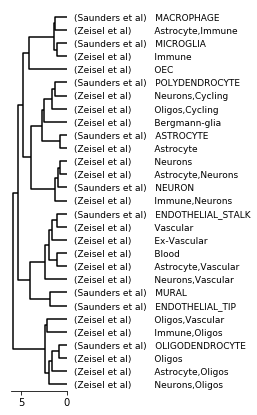

In [113]:
figsize(1, 7)
Zlink = linkage(c_means, method='ward')
dendrogram(Zlink, labels=c_means.index,
           color_threshold=0, orientation='left', leaf_font_size=9,
           above_threshold_color='k');

ax = plt.gca()
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('dendrogram_classes.png', bbox_inches='tight', dpi=150)

In [115]:
t_obs['verbose_name'] = t_obs['ClusterName'] + ' - ' + t_obs['Description']

In [116]:
d_c_means = d_obs.groupby('common_name_').mean()[z_cols]
d_c_means.index = '(Saunders et al)   ' + d_c_means.index
t_c_means = t_obs.groupby('verbose_name').mean()[z_cols]
t_c_means.index = '(Zeisel et al)        ' + t_c_means.index
c_means = pd.concat((t_c_means, d_c_means))

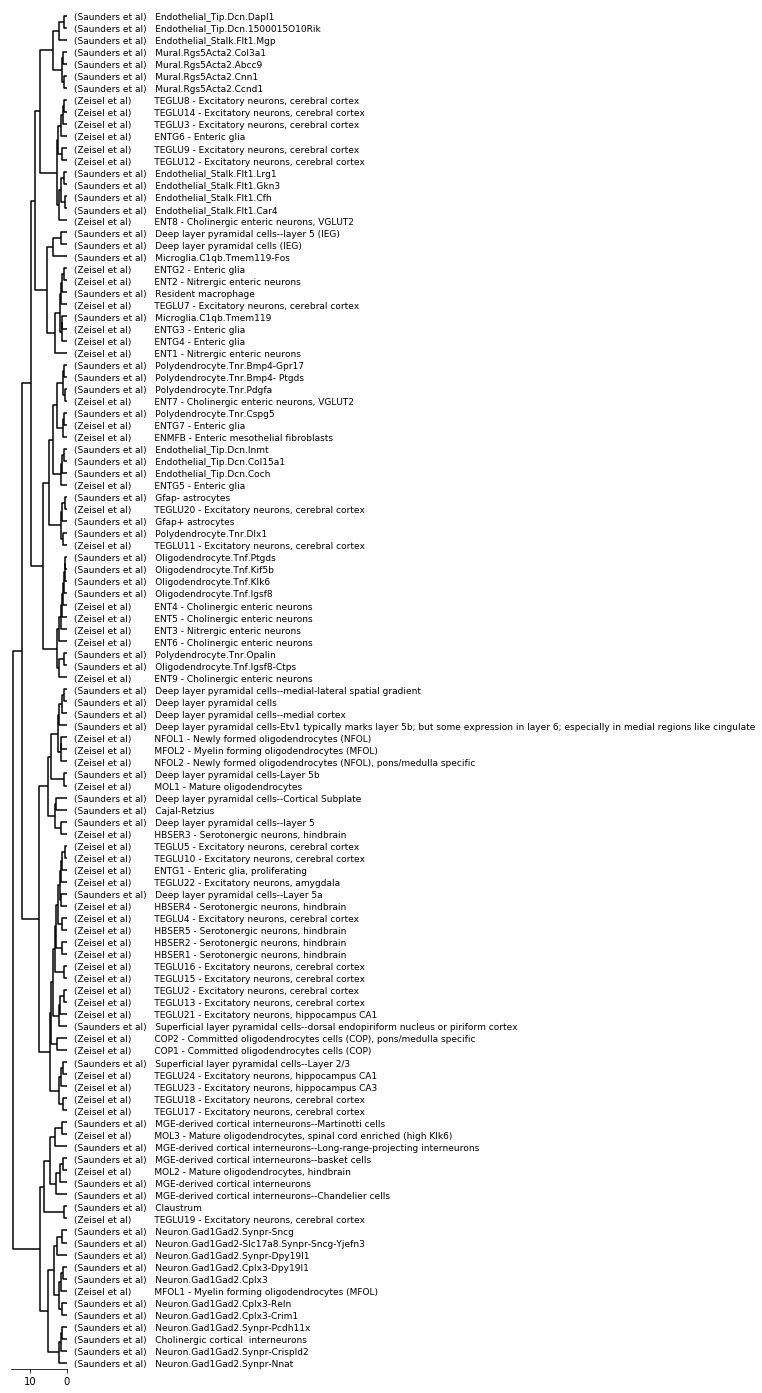

In [117]:
figsize(1, 25)
Zlink = linkage(c_means, method='ward')
dendrogram(Zlink, labels=c_means.index,
           color_threshold=0, orientation='left', leaf_font_size=9,
           above_threshold_color='k');

ax = plt.gca()
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('dendrogram_clusters.png', bbox_inches='tight', dpi=150)

In [79]:
', '.join(d_obs.columns)

'Age, AnalysisPool, AnalysisProject, CellConc, Cell_Conc, ChipID, Class, ClassProbability_Astrocyte, ClassProbability_Astrocyte,Immune, ClassProbability_Astrocyte,Neurons, ClassProbability_Astrocyte,Oligos, ClassProbability_Astrocyte,Vascular, ClassProbability_Bergmann-glia, ClassProbability_Blood, ClassProbability_Blood,Vascular, ClassProbability_Enteric-glia, ClassProbability_Enteric-glia,Cycling, ClassProbability_Ependymal, ClassProbability_Ex-Neurons, ClassProbability_Ex-Vascular, ClassProbability_Immune, ClassProbability_Immune,Neurons, ClassProbability_Immune,Oligos, ClassProbability_Neurons, ClassProbability_Neurons,Cycling, ClassProbability_Neurons,Oligos, ClassProbability_Neurons,Satellite-glia, ClassProbability_Neurons,Vascular, ClassProbability_OEC, ClassProbability_Oligos, ClassProbability_Oligos,Cycling, ClassProbability_Oligos,Vascular, ClassProbability_Satellite-glia, ClassProbability_Satellite-glia,Cycling, ClassProbability_Satellite-glia,Schwann, ClassProbability_Schwa